In [24]:
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, SGDRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from planet.app import Planet

In [25]:
archive = Path('data/export.csv')
index = np.arange(0, 160178, 1)  # количество индексов = количеству строк в файле

quacke_df = pd.read_csv(archive, index_col=False, encoding='windows-1251', sep=';')

non_data = ['Дата', 'Час', 'Мин', 'Сек', 'Ошибка по времени', 'Ошибка по широте', 'Ошибка по долготе', 'Ошибка по глубине', 'Глубина', 'Код сети', 'Сейсмический регион', 'Географический регион', 'Макросейсмические данные']

/tmp/ipykernel_391766/3463654720.py:4: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  quacke_df = pd.read_csv(archive, index_col=False, encoding='windows-1251', sep=';')


In [26]:
def add_param(frame):
    frame['Долгота'] = float(frame['Долгота'].replace(',', '.'))
    frame['Широта'] = float(frame['Широта'].replace(',', '.'))
    date = frame['Дата']
    frame['Магнитуда'] = float(frame['Магнитуда'].replace(',', '.')) 

    planet = Planet(frame['Долгота'], frame['Широта'], date)

    return pd.concat([frame, pd.Series(planet.get_parametrs())])

In [27]:
quacke_df = quacke_df.apply(add_param, axis=1)

quacke_df = quacke_df.drop(non_data, axis=1)
quacke_df = quacke_df.dropna()

quacke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160178 entries, 0 to 160177
Data columns (total 59 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Широта                  160178 non-null  float64
 1   Долгота                 160178 non-null  float64
 2   Магнитуда               160178 non-null  float64
 3   Mercury_earth_distance  160178 non-null  float64
 4   Mercury_sun_distance    160178 non-null  float64
 5   Mercury_hlat            160178 non-null  float64
 6   Mercury_hlon            160178 non-null  float64
 7   Mercury_size            160178 non-null  float64
 8   Mercury_radius          160178 non-null  float64
 9   Mercury_a_ra            160178 non-null  float64
 10  Mercury_elong           160178 non-null  float64
 11  Venus_earth_distance    160178 non-null  float64
 12  Venus_sun_distance      160178 non-null  float64
 13  Venus_hlat              160178 non-null  float64
 14  Venus_hlon          

In [28]:
target_column = 'Магнитуда'
y = quacke_df[target_column]
X = quacke_df.drop(target_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
linear_model = Pipeline([('quad', PolynomialFeatures(degree=2)), ('lr', LinearRegression())])
linear_model.fit(X_train, y_train)

ridge_model = RidgeCV(alphas=(0.1, 1, 10), cv=20)
ridge_model.fit(X_train, y_train)

lasso_model = LassoCV(cv=20)
lasso_model.fit(X_train, y_train)

sgd_model = make_pipeline(StandardScaler(), SGDRegressor(max_iter=200, tol=1e-3))
sgd_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(max_iter=200))])

### Расчет точности предсказаний

In [30]:
linear_score = cross_val_score(linear_model, X_test, y_test, cv=3)
ridge_score = ridge_model.score(X_test, y_test)
lasso_score = lasso_model.score(X_test, y_test)
sgd_score = sgd_model.score(X_test, y_test)

In [31]:
print(linear_score.mean(), ridge_score, lasso_score, sgd_score)

0.3160236826447596 0.17648144837441537 0.16587186885456218 0.17249193160279597


Линейная модель показывает хорошую точность только на имеющхся данных, будующие прогнозы крайне неточные (в том числе отрицательные значения)

In [32]:
y_lin = linear_model.predict(X_test)
y_ridge = ridge_model.predict(X_test)
y_lasso = lasso_model.predict(X_test)
y_sgd = sgd_model.predict(X_test)

x = np.arange(1, len(y_test)+1,1)[:100]
pic_y_lin = pd.Series(y_lin[:100]).set_axis(x)
pic_y_lasso = pd.Series(y_lasso[:100]).set_axis(x)
pic_y_test = y_test[:100].set_axis(x)
pic_y_ridge = pd.Series(y_ridge[:100]).set_axis(x)
pic_y_sgd = pd.Series(y_sgd[:100]).set_axis(x)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

med_ae = median_absolute_error(y_test, y_ridge)
mae = mean_absolute_error(y_test, y_ridge)
mse = mean_squared_error(y_test, y_ridge, squared=False)
cvs = cross_val_score(ridge_model, X_test, y_test, cv=3).mean() # вероятно этот показатель здесь не нужен, насколько я понимаю он применется на тренировочной или полной выборке
message = """Коэфициент детерминации - {0},\n
Средняя абсолютная ошибка - {1},\n
Среднее абсолютное отклонение - {2},\n
Среднеквадратичное отклонение - {3},\n
Перекрестная проверка - {4},\n 
""".format(ridge_score, med_ae, mae, mse, cvs)
print(message)

Коэфициент детерминации - 0.17648144837441537,

Средняя абсолютная ошибка - 0.5445095991649704,

Среднее абсолютное отклонение - 0.6455354657635425,

Среднеквадратичное отклонение - 0.8303204305453402,

Перекрестная проверка - 0.17593758047499508,
 



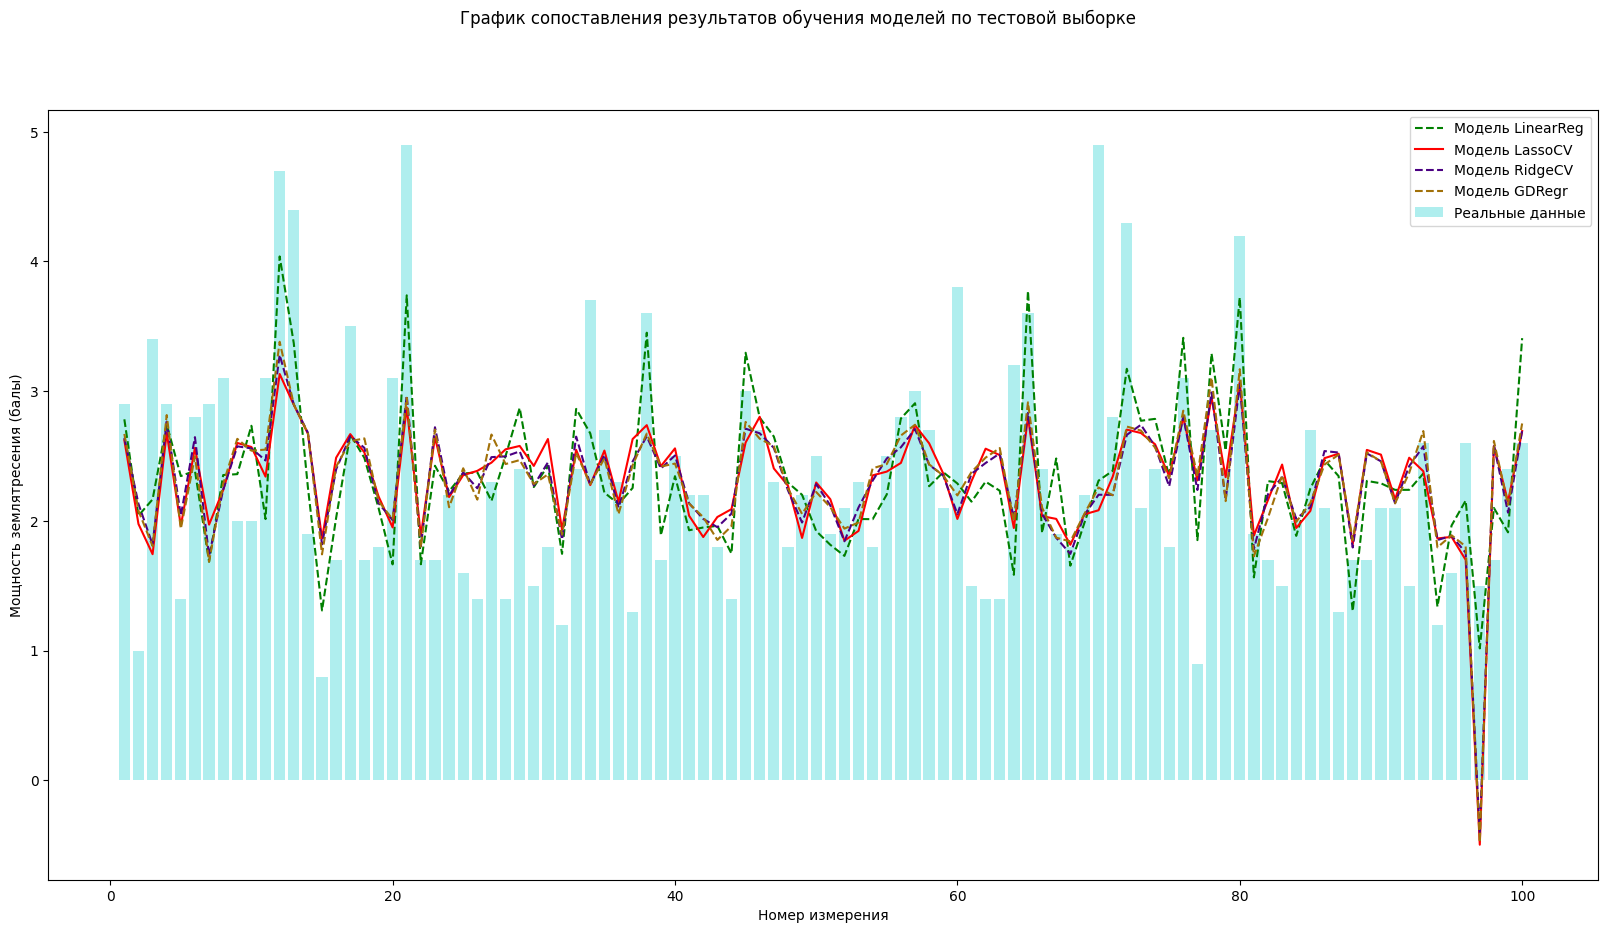

In [33]:
plt.figure(figsize=(20,10))
plt.suptitle('График сопоставления результатов обучения моделей по тестовой выборке')

plt.bar(x, pic_y_test,label='Реальные данные', color='#AFEEEE')
plt.plot(pic_y_lin, '--', color='g', label='Модель LinearReg')
plt.plot(pic_y_lasso, '-r', label='Модель LassoCV')
plt.plot(pic_y_ridge, '--', color='#4B0082', label='Модель RidgeCV')
plt.plot(pic_y_sgd, '--', color='#A27109', label='Модель GDRegr')

plt.xlabel('Номер измерения')
plt.ylabel('Мощность землятресения (балы)')
plt.legend(loc='best')

plt.show()

In [34]:
joblib.dump(linear_model, 'models/linear_model.pkl')
joblib.dump(ridge_model, 'models/ridge_model.pkl') 
joblib.dump(lasso_model, 'models/lasso_model.pkl')
joblib.dump(lasso_model, 'models/sgd_model.pkl')

['models/sgd_model.pkl']